# Business Objective

Prediksi apakah suatu perusahaan yang mengajukan IPO dapat sukses dan meraih keuntungan atau tidak?

- Faktor pengukuran kesuksesan biasanya dilihat dari banyaknya orang yang mau beli sahamnya atau tidak.

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

## Load Data

In [45]:
df = pd.read_csv("../Filip/mod_data.csv")

df.head()

,Ticker,Nama Perusahaan,Tanggal Listing,Sektor,Underwriter,Papan Pencatatan,Ownership,Listed Share,Persen Saham Ditawarkan,Rencana Penggunaan Dana IPO,...,Total Liabilitas,Pendapatan,Laba Kotor,Laba Berjalan (Bukan Komperhensif),Harga Final,1D %,1W %,1M %,6M %,1Y %
0,UNIQ,PT Ulima Nitra Tbk,8-Mar-21,Energy,PT Surya Fajar Sekuritas,utama,lainnya,3.138983e+09,0.0956,modal kerja,...,2.670000e+11,2.710000e+11,2.454700e+10,-5.617000e+09,118,999,35,5.0,-25.0,-30.0
1,GTRA,PT Grahaprima Suksesmandiri Tbk,30-Mar-23,Transportation & Logistic,PT UOB Kay Hian Sekuritas,pengembangan,lainnya,1.894375e+09,0.2000,modal belanja,...,4.570000e+11,1.950000e+11,8.756900e+10,1.130000e+11,150,999,85,77.0,39.0,9.0
2,BSBK,PT Wulandari Bangun Laksana Tbk,8-Nov-22,Properties & Real Estate,PT KGI Sekuritas Indonesia; PT Panca Global Se...,pengembangan,lainnya,2.275000e+10,0.1209,modal kerja,...,1.120000e+12,5.590600e+10,3.895000e+10,-1.943000e+09,100,999,170,140.0,-50.0,-50.0
3,COAL,PT Black Diamond Resources Tbk,7-Sep-22,Energy,PT Surya Fajar Sekuritas,pemantauan khusus,lainnya,6.250000e+09,0.2000,modal kerja,...,2.500000e+14,9.553076e+10,4.902891e+10,4.330173e+10,100,999,280,354.0,36.0,-45.0
4,CRAB,PT Toba Surimi Industries Tbk,10-Aug-22,Consumer Non-Cyclicals,PT KGI Sekuritas Indonesia,pengembangan,lainnya,1.950000e+09,0.2000,modal kerja,...,2.470000e+11,1.360000e+11,1.738746e+10,2.926422e+09,150,999,56,59.0,41.0,59.0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Ticker                              223 non-null    object 
 1   Nama Perusahaan                     223 non-null    object 
 2   Tanggal Listing                     223 non-null    object 
 3   Sektor                              223 non-null    object 
 4   Underwriter                         223 non-null    object 
 5   Papan Pencatatan                    223 non-null    object 
 6   Ownership                           223 non-null    object 
 7   Listed Share                        223 non-null    float64
 8   Persen Saham Ditawarkan             223 non-null    float64
 9   Rencana Penggunaan Dana IPO         223 non-null    object 
 10  Valuation Currency                  223 non-null    object 
 11  Total Aset                          223 non-n

### Small Explanations:

This's a classification problem to classify this target columns:

- **Harga Final**: Harga final penawaran saham yang ditetapkan
- **1D %**: Persentase keuntungan / kerugian harga saham pada hari pertama perdagangan. (Ngukur initial pop sebuah IPO)
    - Multiclass Classification:
        'ARA': kinerja luar biasa, harga menyentuh batas kenaikan harian.
        'Naik': kinerja positif, tidak mencapai ARA
        'Turun': kinerja negatif
- **1W %**
- **1M %**
- **6M %**
- **1Y %**

Sisanya literally persentase keuntungan dan kerugian saham berdasarkan periode waktu.

## Exploratory Data Analysis & Preprocessing

### 1. Ubah beberapa kolom ke dalam float

In [47]:
cols_to_float = ['Listed Share', 'Total Aset', 'Total Liabilitas', 'Pendapatan', 'Harga Final']
df[cols_to_float] = df[cols_to_float].astype(float)

### 2. Menghilangkan persentase ("%")

In [48]:
cols_percent = ['1D %', '1W %', '1M %', '6M %', '1Y %']
df[cols_percent] = df[cols_percent].replace('%', '', regex=True).astype(float)

### 3. Missing Value

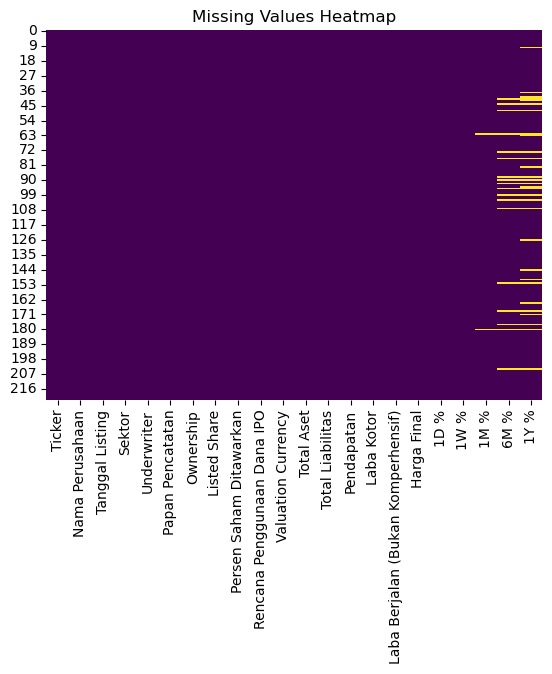

In [49]:
sns.heatmap(df.isna(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

## Feature Engineering

### Creating a Classification Problem

1. Mengubah kolom 1D % dari numerik menjadi kategorikal berdasarkan ARA.

Jika 1D % == 999 -> maka kita ubah jadi ARA, sedangkan kalau 1D % > 0 -> maka kita ubah jadi plus, dan kalau 1D % < 0, kita ubah jadi minus.

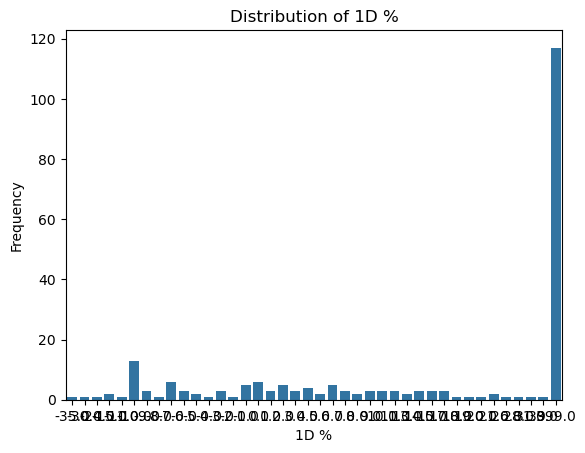

In [50]:
sns.countplot(x="1D %", data=df)
plt.title('Distribution of 1D %')
plt.xlabel('1D %')
plt.ylabel('Frequency')
plt.show()

Sekarang kalau kita ubah:

In [51]:
df['1D %'] = df['1D %'].apply(lambda x: 'ARA' if x == 999 else ('plus' if x >= 0 else 'minus'))

Maka, akan menjadi kolom kategorikal dengan distribusi sebagai berikut:

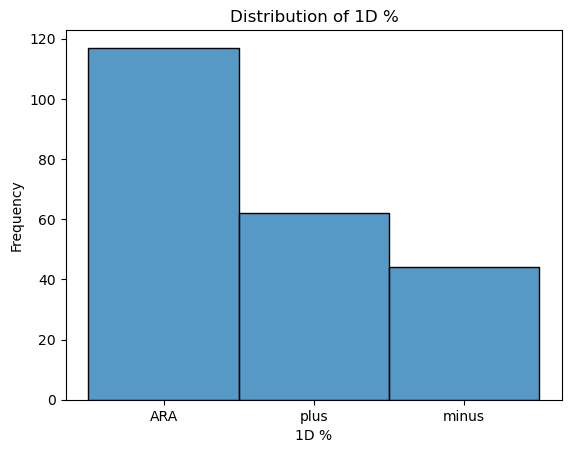

In [52]:
sns.histplot(df["1D %"], bins=30)
plt.title('Distribution of 1D %')
plt.xlabel('1D %')
plt.ylabel('Frequency')
plt.show()

Untuk kolom target seperti 1W %, 1M %, 6M %, dan 1Y% masih merupakan kolom numerik. Jadi, kita dapat cek distribusi-nya terlebih dahulu.

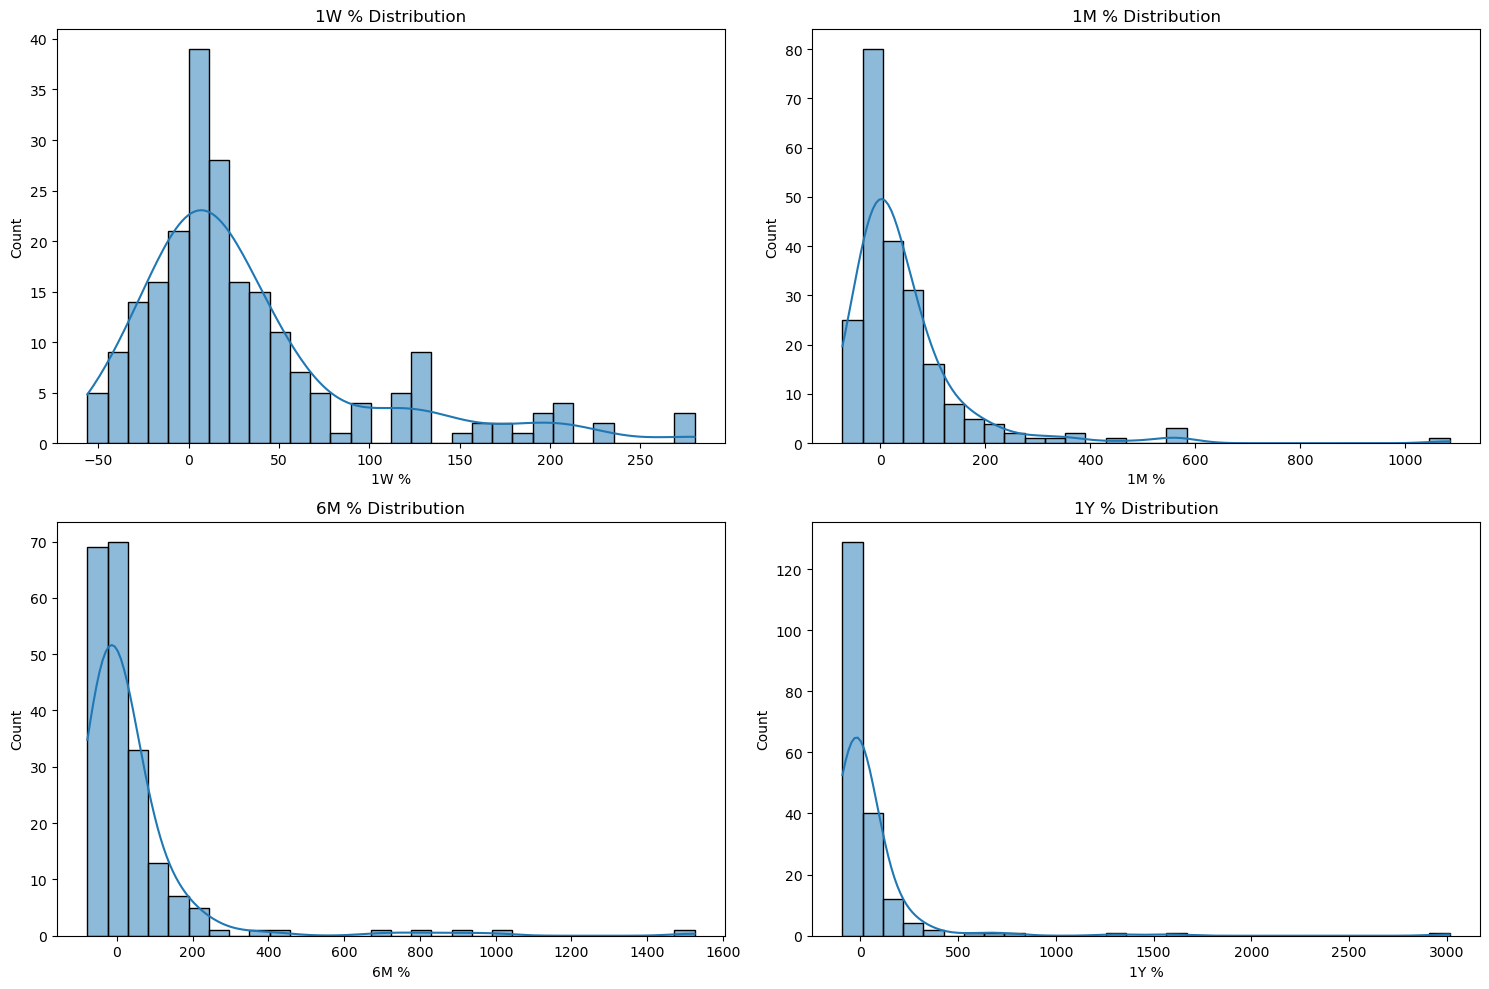

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df['1W %'].dropna(), bins=30, ax=ax[0, 0], kde=True)
sns.histplot(df['1M %'].dropna(), bins=30, ax=ax[0, 1], kde=True)
sns.histplot(df['6M %'].dropna(), bins=30, ax=ax[1, 0], kde=True)
sns.histplot(df['1Y %'].dropna(), bins=30, ax=ax[1, 1], kde=True)
ax[0, 0].set_title('1W % Distribution')
ax[0, 1].set_title('1M % Distribution')
ax[1, 0].set_title('6M % Distribution')
ax[1, 1].set_title('1Y % Distribution')
plt.tight_layout()
plt.show()

Ubah kolom 1W % dan kolom 1M % menjadi 2 kategori yaitu good dan bad

In [54]:
def categorize_mid(val):
    if pd.isnull(val):
        return val
    return 'good' if val >= 5 else 'bad'

for col in ['1W %', '1M %']:
    df[col] = df[col].apply(categorize_mid)

Ubah kolom 6M % dan kolom 1Y % menjadi 2 kategori yaitu plus dan minus

In [55]:
def categorize_long(val):
    if pd.isnull(val):
        return val
    elif val >= 0:
        return 'plus'
    else:
        return 'minus'
    
for col in ['6M %', '1Y %']:
    df[col] = df[col].apply(categorize_long)

#### Conclusions

Jadi, kita punya sekarang punya target label berupa kategorikal columns.

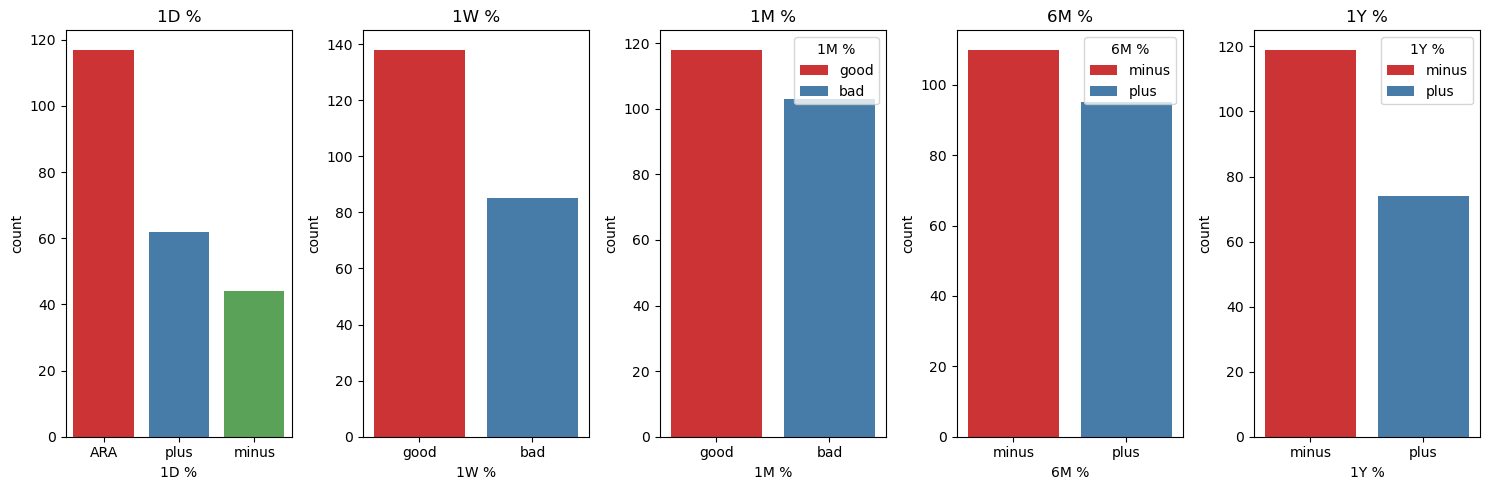

In [56]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
sns.countplot(x='1D %', data=df, ax=ax[0], hue='1D %', palette='Set1')
sns.countplot(x='1W %', data=df, ax=ax[1], hue='1W %', palette='Set1')
sns.countplot(x='1M %', data=df, ax=ax[2], hue='1M %', palette='Set1')
sns.countplot(x='6M %', data=df, ax=ax[3], hue='6M %', palette='Set1')
sns.countplot(x='1Y %', data=df, ax=ax[4], hue='1Y %', palette='Set1')
ax[0].set_title('1D %')
ax[1].set_title('1W %')
ax[2].set_title('1M %')
ax[3].set_title('6M %')
ax[4].set_title('1Y %')
plt.tight_layout()
plt.show()

### 1. Datetime

In [57]:
df['Tanggal Listing'] = pd.to_datetime(df['Tanggal Listing'], format='%d-%b-%y', errors='coerce')
df.sort_values('Tanggal Listing', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Ticker,Nama Perusahaan,Tanggal Listing,Sektor,Underwriter,Papan Pencatatan,Ownership,Listed Share,Persen Saham Ditawarkan,Rencana Penggunaan Dana IPO,...,Total Liabilitas,Pendapatan,Laba Kotor,Laba Berjalan (Bukan Komperhensif),Harga Final,1D %,1W %,1M %,6M %,1Y %
0,UNIQ,PT Ulima Nitra Tbk,2021-03-08,Energy,PT Surya Fajar Sekuritas,utama,lainnya,3.138983e+09,0.0956,modal kerja,...,2.670000e+11,2.710000e+11,2.454700e+10,-5.617000e+09,118.0,ARA,good,good,minus,minus
1,ARCI,PT Archi Indonesia Tbk,2021-06-28,Basic Materials,PT BNI Sekuritas; PT Mandiri Sekuritas; PT Cit...,pengembangan,konglomerat,2.483500e+10,0.1500,bayar hutang,...,6.860000e+12,4.960000e+12,2.710000e+12,1.490000e+12,750.0,plus,bad,bad,minus,minus
2,MASB,PT Bank Multiarta Sentosa Tbk,2021-06-30,Financials,PT BCA Sekuritas,pemantauan khusus,lainnya,1.226903e+09,0.1500,modal kerja,...,1.960000e+13,1.210000e+12,4.310000e+11,1.080000e+11,3360.0,ARA,bad,bad,plus,plus
3,BMHS,PT Bundamedik Tbk,2021-07-06,Healthcare,PT Ciptadana Sekuritas Asia,utama,konglomerat,8.603416e+09,0.0726,bayar hutang,...,1.110000e+12,1.150000e+12,3.680000e+11,1.180000e+11,340.0,ARA,good,good,plus,plus
4,UVCR,PT Trimegah Karya Pratama Tbk,2021-07-27,Technology,PT Surya Fajar Sekuritas; PT Mirae Asset Sekur...,pengembangan,lainnya,2.000000e+09,0.2500,modal belanja,...,1.435880e+10,1.940000e+11,4.634337e+09,5.434916e+08,100.0,ARA,good,good,plus,plus


### 2. Underwriter

Ini part/fitur paling penting yang jadi patokan orang-orang dalam menentukan apakah dia akan beli saham atau engga.

Insight yang didapat:
- Underwriter mampu membawa harga saham naik.
- Underwriter yang secara historikal dia ampir selalu ngebawa harga sahamnya naik (contohnya ciptadana, trimegah, henan) -> **Ini yang wajib kita catat**
- Underwriter berupa bank gede (biasanya saham yang di bawa dia cenderung sideways (ga naik, ga turun)) (contohnya bca, bri, bni)
- Semakin sering underwriter menjadi bagian yang mempengaruhi saham, semakin tinggi orang-orang pada mau beli tu saham.


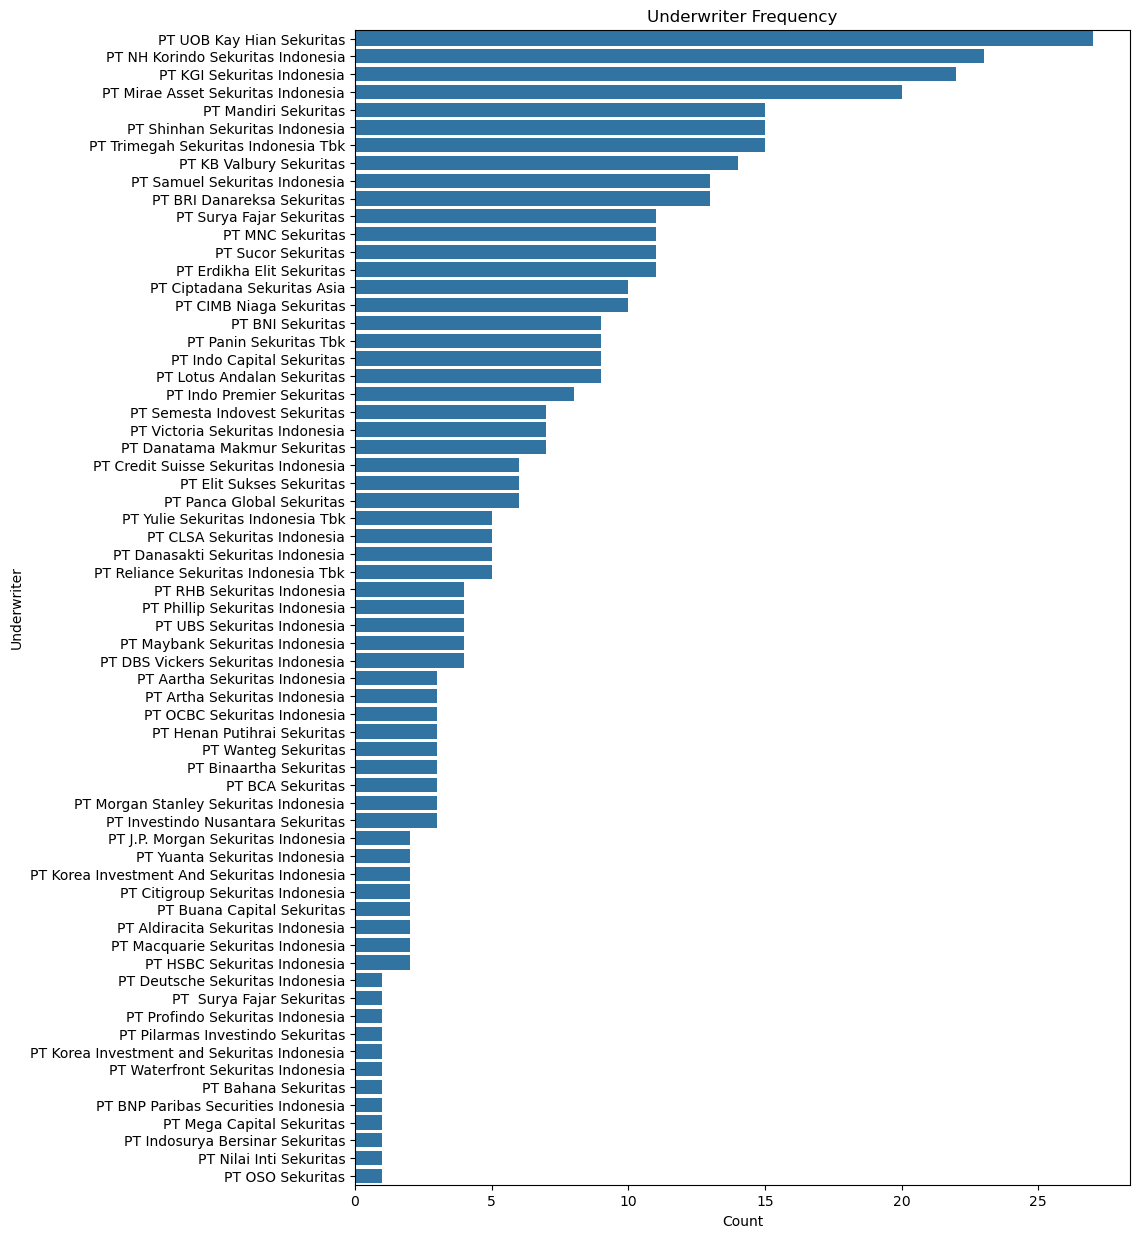

In [58]:
underwriters_exploded = df['Underwriter'].str.split(';').explode().str.strip()
plt.figure(figsize=(10, 15))
sns.countplot(y=underwriters_exploded, order=underwriters_exploded.value_counts().index)
plt.ylabel('Underwriter')
plt.xlabel('Count')
plt.title('Underwriter Frequency')
plt.show()

Sekarang, kita bisa melihat:
1. Underwriter mana yang:
    - paling aktif `freq`
    - cenderung menangani perusahaan besar `avg_aset`
    - mengelola penawaran saham bernilai tinggi `avg_jumlah`
2. Spesialisasi underwriter (apakah ada underwriter yang spesialis di sektor perusahaan dengan aset besar atau kecil?)

Ini juga bakal jadi pertimbangan buat perusahaan buat milih underwriter yang tepat buat perusahaan dia.

In [59]:
freq_dict = {}
aset_dict = {}
jumlah_dict = {}

for idx, row in df.iterrows():
    underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]
    persen = row['Persen Saham Ditawarkan']
    listed_share = row['Listed Share']
    harga_final = row['Harga Final']
    total_aset = row['Total Aset']
    
    jumlah = listed_share * harga_final * persen
    for uw in underwriters:
        freq_dict[uw] = freq_dict.get(uw, 0) + 1
        aset_dict[uw] = aset_dict.get(uw, 0.0) + total_aset
        jumlah_dict[uw] = jumlah_dict.get(uw, 0.0) + jumlah

uw_stats = []
for uw in freq_dict:
    freq = freq_dict[uw]
    avg_aset = aset_dict[uw] / freq if freq else 0
    avg_jumlah = jumlah_dict[uw] / freq if freq else 0
    uw_stats.append((uw, freq, avg_aset, avg_jumlah))

uw_df = pd.DataFrame(uw_stats, columns=['underwriter', 'freq', 'avg_aset', 'avg_jumlah']).reset_index(drop=True)
uw_df.head()

,underwriter,freq,avg_aset,avg_jumlah
0,PT Surya Fajar Sekuritas,11,1.894937e+11,1.059479e+11
1,PT BNI Sekuritas,9,3.898356e+13,4.461379e+12
2,PT Mandiri Sekuritas,15,2.824633e+13,6.182559e+12
3,PT Citigroup Sekuritas Indonesia,2,2.134000e+13,6.393589e+12
4,PT Credit Suisse Sekuritas Indonesia,6,4.180333e+13,8.209206e+12


In [60]:
high_aset = uw_df['avg_aset'].quantile(0.75)
low_aset = uw_df['avg_aset'].quantile(0.25)

def aset_category(val):
    if val >= high_aset:
        return 'high'
    elif val <= low_aset:
        return 'low'
    else:
        return 'mid'

uw_df['avg_aset_category'] = uw_df['avg_aset'].apply(aset_category)

high_freq = uw_df['freq'].quantile(0.75)
low_freq = uw_df['freq'].quantile(0.25)

def freq_category(val):
    if val >= high_freq:
        return 'high'
    elif val <= low_freq:
        return 'low'
    else:
        return 'mid'

uw_df['freq_category'] = uw_df['freq'].apply(freq_category)
uw_df.head()

,underwriter,freq,avg_aset,avg_jumlah,avg_aset_category,freq_category
0,PT Surya Fajar Sekuritas,11,1.894937e+11,1.059479e+11,low,high
1,PT BNI Sekuritas,9,3.898356e+13,4.461379e+12,high,high
2,PT Mandiri Sekuritas,15,2.824633e+13,6.182559e+12,high,high
3,PT Citigroup Sekuritas Indonesia,2,2.134000e+13,6.393589e+12,high,low
4,PT Credit Suisse Sekuritas Indonesia,6,4.180333e+13,8.209206e+12,high,mid


Sekarang, kita akan mengelompokkan para underwriter berdasarkan dua metrik yang sudah dihitung sebelumnya:
- rata-rata aset
- frekuensi

Pengelompokkan akan dilakukan menggunakan metode kuantil untuk membagi underwriter ke 3 grup yaitu `high`, `mid`, dan `low`

In [61]:
high_aset = uw_df['avg_aset'].quantile(0.75)
low_aset = uw_df['avg_aset'].quantile(0.25)

In [62]:
def aset_category(val):
    if val >= high_aset:
        return 'high'
    elif val <= low_aset:
        return 'low'
    else:
        return 'mid'
    
uw_df['avg_aset_category'] = uw_df['avg_aset'].apply(aset_category)

In [63]:
high_freq = uw_df['freq'].quantile(0.75)
low_freq = uw_df['freq'].quantile(0.25)

In [64]:
def freq_category(val):
    if val >= high_freq:
        return 'high'
    elif val <= low_freq:
        return 'low'
    else:
        return 'mid'

uw_df['freq_category'] = uw_df['freq'].apply(freq_category)

Final check:

In [65]:
uw_df.head()

,underwriter,freq,avg_aset,avg_jumlah,avg_aset_category,freq_category
0,PT Surya Fajar Sekuritas,11,1.894937e+11,1.059479e+11,low,high
1,PT BNI Sekuritas,9,3.898356e+13,4.461379e+12,high,high
2,PT Mandiri Sekuritas,15,2.824633e+13,6.182559e+12,high,high
3,PT Citigroup Sekuritas Indonesia,2,2.134000e+13,6.393589e+12,high,low
4,PT Credit Suisse Sekuritas Indonesia,6,4.180333e+13,8.209206e+12,high,mid


Oke, sekarang kita tinggal implementasiin aja ke dataset asli kita.

1. Buat kolom baru `lead_underwriter`

In [66]:
df['lead_underwriter'] = df['Underwriter'].str.split(';').str[0].str.strip()

2. Buat dictionary berdasarkan `freq` dan `avg` tadi buat di mapping.

In [67]:
uw_map_freq_cat = uw_df.set_index('underwriter')['freq_category'].to_dict()
uw_map_aset_cat = uw_df.set_index('underwriter')['avg_aset_category'].to_dict()

3. Buat kategorikal kolom baru (2 buah) dengan mapping dictionary yang tadi.

In [68]:
df['underwriter_freq_category'] = df['lead_underwriter'].map(uw_map_freq_cat)
df['underwriter_avg_aset_category'] = df['lead_underwriter'].map(uw_map_aset_cat)

Sekarang, kita akan cek performa saham dengan kategori underwriter yang udah kita buat.

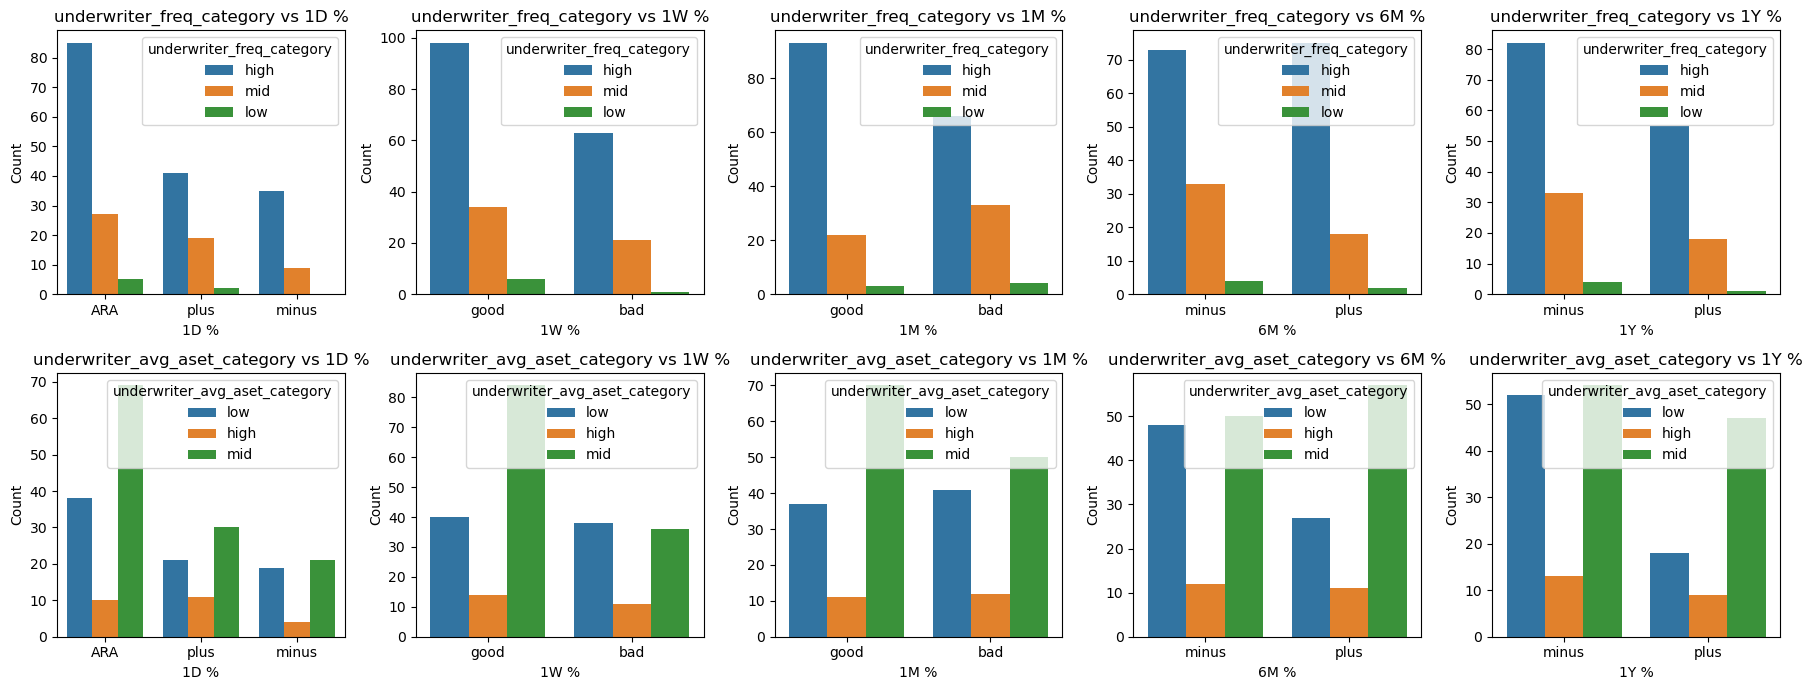

In [69]:
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
target_cols = ['1D %', '1W %', '1M %', '6M %', '1Y %']
plot_cols = ['underwriter_freq_category', 'underwriter_avg_aset_category']

for i, col in enumerate(plot_cols):
    for j, target in enumerate(target_cols):
        ax = axes[i, j]
        sns.countplot(x=df[target], hue=df[col], ax=ax)
        ax.set_title(f"{col} vs {target}")
        ax.set_xlabel(target)
        ax.set_ylabel('Count')
        ax.legend(title=col, loc='best')

plt.tight_layout()
plt.show()

**Apakah ada hubungan antara tipe underwriter (berdasarkan frekuensi atau aset klien) dengan kinerja harga saham IPO dalam jangka pendek hingga panjang?**

Insight:
1. Underwriter `high` mendominasi pasar IPO.
2. Underwriter `high` juga mendominasi pasar IPO yang kinerjanya juga buruk. (Hanya karena sebuah underwriter sering menangani IPO, bukan berarti IPO yang mereka tangani selalu berkinerja baik).
3. Underwriter `low` adalah minoritas dalam pasar IPO.

Conclusions:
- Tidak ada satu kategori underwriter yang secara konsisten menghasilkan kinerja IPO yang baik. Kategori `high-freq` dan `mid-aset` meskipun merupakan kategori yang mendominasi data, dia juga merupakan kategori dengan penyumbang kinerja negatif terbanyak.

**Dari seluruh IPO yang ditangani oleh underwriter Tipe X, berapa persen yang kinerjanya positif dan berapa persen yang negatif?**

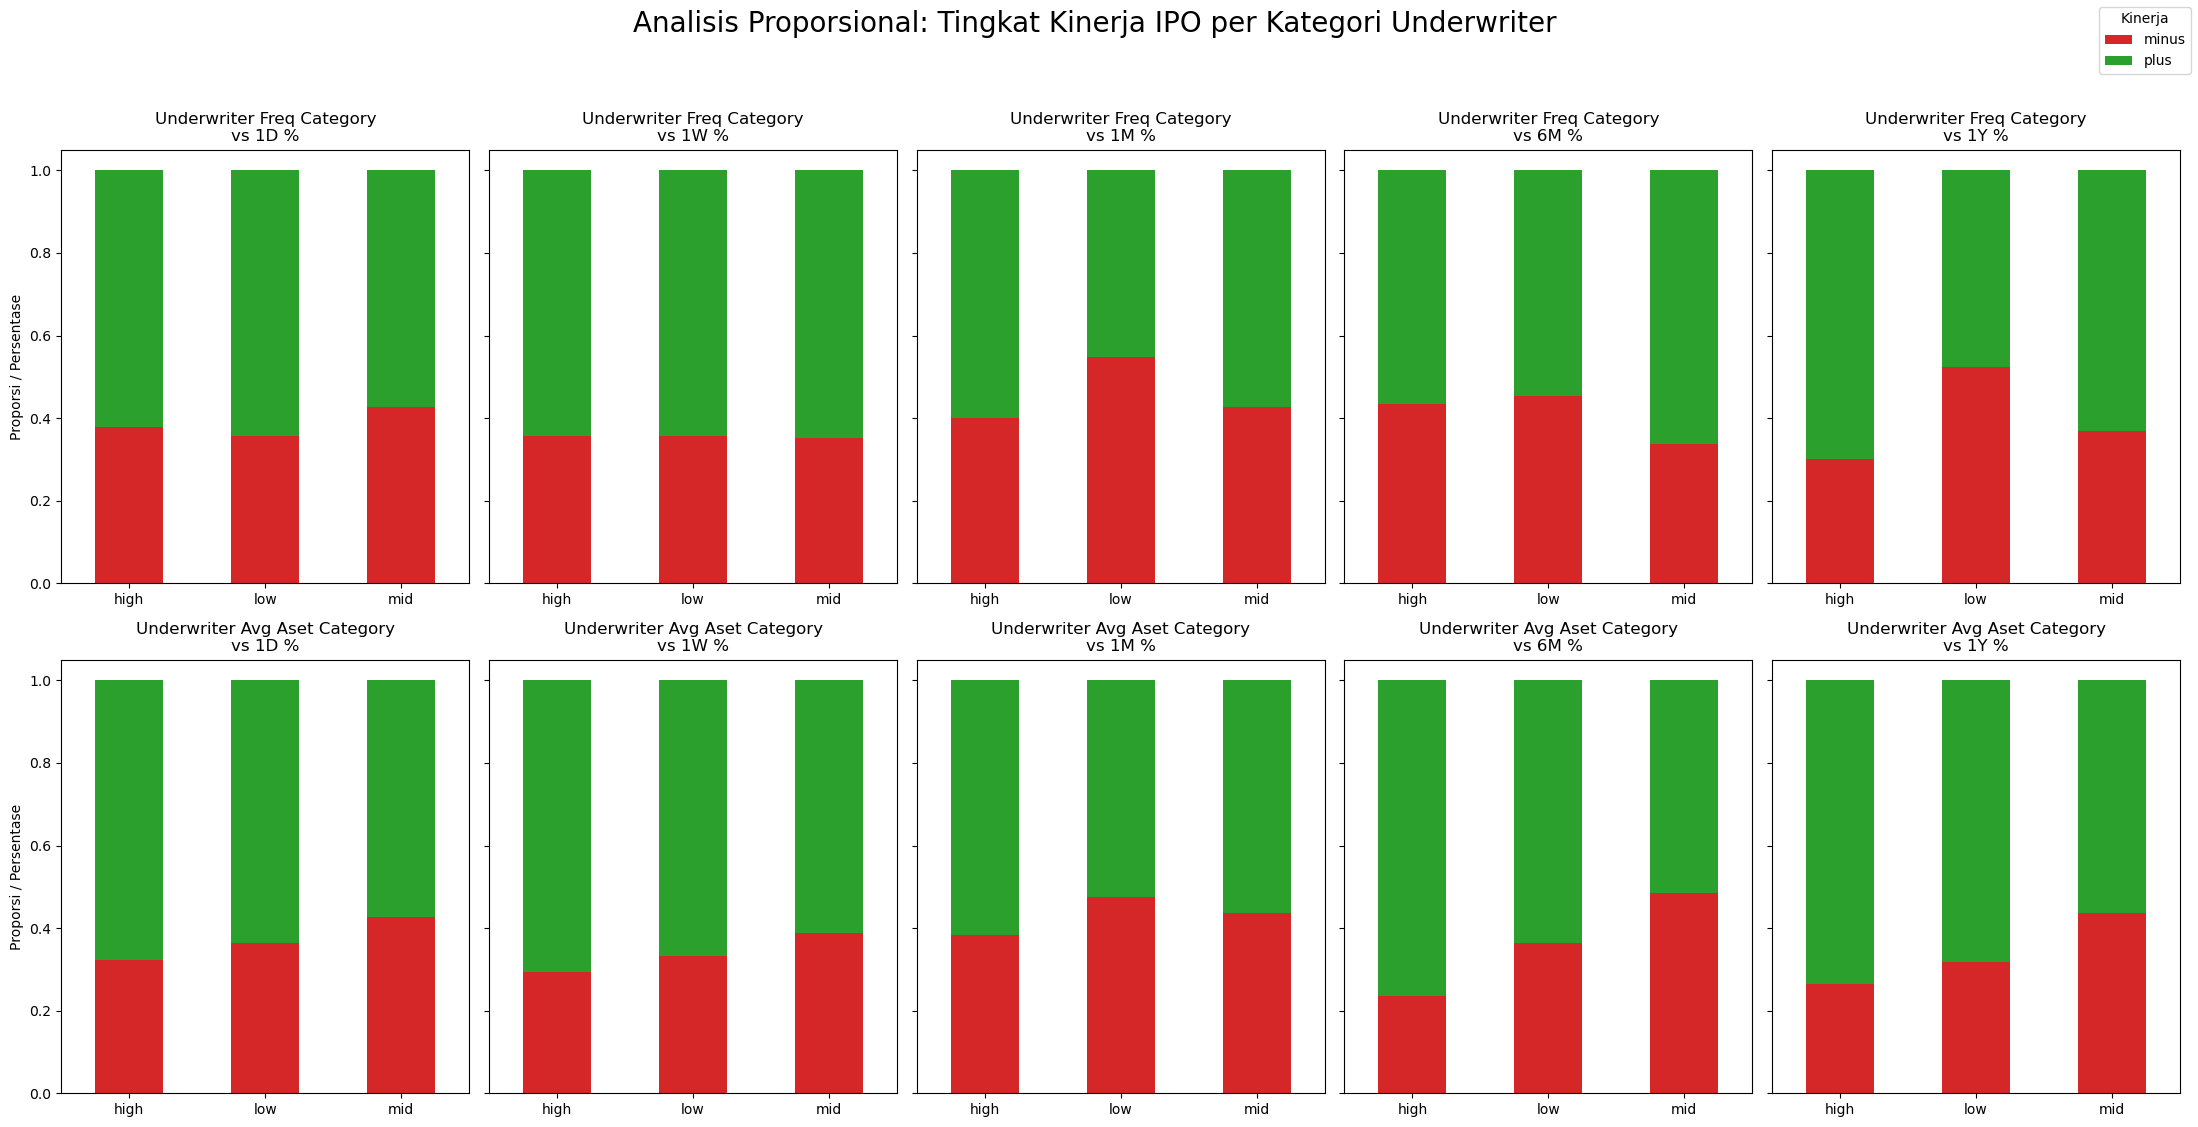

In [70]:
num_samples = 200
uw_freq_dist = ['high'] * 250 + ['mid'] * 150 + ['low'] * 100
uw_aset_dist = ['mid'] * 250 + ['low'] * 150 + ['high'] * 100

df_sim = pd.DataFrame({
    'underwriter_freq_category': np.random.choice(uw_freq_dist, num_samples),
    'underwriter_avg_aset_category': np.random.choice(uw_aset_dist, num_samples)
})

perf_outcomes = ['plus', 'minus']
for period in ['1D', '1W', '1M', '6M', '1Y']:
    probs = np.random.rand(num_samples)
    df_sim[f'perf_{period}'] = np.where(probs > 0.4, 'plus', 'minus')

fig, axes = plt.subplots(2, 5, figsize=(22, 11), sharey=True)
fig.suptitle('Analisis Proporsional: Tingkat Kinerja IPO per Kategori Underwriter', fontsize=20, y=1.02)
category_cols = ['underwriter_freq_category', 'underwriter_avg_aset_category']
perf_cols = [f'perf_{period}' for period in ['1D', '1W', '1M', '6M', '1Y']]
time_labels = ['1D %', '1W %', '1M %', '6M %', '1Y %']

colors = {'plus': '#2ca02c', 'minus': '#d62728'}

for row_idx, cat_col in enumerate(category_cols):
    for col_idx, (perf_col, time_label) in enumerate(zip(perf_cols, time_labels)):
        ax = axes[row_idx, col_idx]
        ct = pd.crosstab(df_sim[cat_col], df_sim[perf_col])
        ct_prop = ct.div(ct.sum(axis=1), axis=0)
        ct_prop.plot(kind='bar', stacked=True, ax=ax, color=[colors[c] for c in ct_prop.columns])
        ax.set_title(f'{cat_col.replace("_", " ").title()}\nvs {time_label}', fontsize=12)
        ax.set_ylabel('Proporsi / Persentase' if col_idx == 0 else '')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=0)
        ax.legend().set_visible(False)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Kinerja')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Gambar diatas nunjukin kalau tidak ada satu tipe underwriter terbaik untuk semua kondisi. Semua balik ke tujuan konsumen masing-masing.

##### Insight 1: Mau untung di hari pertama IPO
Berdasarkan Frekuensi (Baris Atas, Grafik 1D):
- Underwriter high-frequency memiliki tingkat keberhasilan (porsi hijau) yang paling tinggi, sekitar 70%.
- Underwriter mid-frequency dan low-frequency memiliki tingkat keberhasilan yang заметно lebih rendah, hanya sekitar 50-55%.

Berdasarkan Aset (Baris Bawah, Grafik 1D):
- Underwriter spesialis high-asset menunjukkan tingkat keberhasilan tertinggi, mendekati 80%.
- Semua kategori aset sebenarnya berkinerja baik di hari pertama (>70% sukses), namun kategori high sedikit unggul.

**Kesimpulan**: Untuk strategi "beli pagi jual sore" di hari IPO, memilih underwriter yang sering menangani IPO (high-freq) atau yang berspesialisasi pada perusahaan aset besar (high-asset) secara statistik memberikan peluang keberhasilan tertinggi.

##### Insight 2: Pola Anomali setelah 1 bulan IPO
Berdasarkan Frekuensi (Baris Atas, Grafik 1M):
- Underwriter low-frequency secara mengejutkan menunjukkan tingkat keberhasilan yang paling superior, dengan porsi hijau mencapai lebih dari 70%.
- Kinerja high-frequency dan mid-frequency justru biasa saja, dengan tingkat keberhasilan sekitar 52-55%.

Berdasarkan Aset (Baris Bawah, Grafik 1M):
- Pola serupa terjadi di sini. Underwriter spesialis low-asset memiliki tingkat keberhasilan tertinggi, mencapai hampir 80%.

**Kesimpulan**: Ini adalah temuan yang sangat menarik. Underwriter yang lebih kecil atau "butik" (low-freq dan low-asset) tampaknya lebih unggul dalam jangka waktu 1 bulan.

##### Insight 3: Performa Jangka Panjang (6 Bulan - 1 Tahun)
Berdasarkan Frekuensi (Baris Atas, Grafik 6M & 1Y):
- Underwriter mid-frequency secara konsisten menjadi yang terlemah, dengan tingkat keberhasilan hanya sekitar 55%.
- Baik underwriter high-frequency maupun low-frequency menunjukkan rekam jejak jangka panjang yang jauh lebih baik, dengan tingkat keberhasilan stabil di sekitar 70%.

Berdasarkan Aset (Baris Bawah, Grafik 6M & 1Y):
- Semua kategori aset menunjukkan kinerja jangka panjang yang sangat kuat, dengan tingkat keberhasilan mendekati 80%.
- Pada markah 1 tahun, spesialis high-asset dan mid-asset sedikit mengungguli low-asset, namun perbedaannya tidak signifikan.

**Kesimpulan**: Jika Anda adalah investor jangka panjang, sebaiknya hindari underwriter mid-frequency. Dari segi spesialisasi aset, tampaknya fundamental pasar secara umum cukup kuat untuk mengangkat kinerja mayoritas IPO setelah 6 bulan, terlepas dari ukuran aset awal perusahaan.

**Apakah underwriter untuk IPO ini sedang 'panas' (on a hot streak) atau 'dingin' (on a cold streak) berdasarkan kinerja terakhir mereka?**

Nah, kita akan catet di kolom baru yaitu `avg_last3_weighted`

In [71]:
weights_1d = {'minus': 0.33, 'plus': 0.67, 'ARA': 1}
weights_1w_1m = {'bad': 0.5, 'good': 1}
weights_rest = {'minus': 0.5, 'plus': 1}

df_sorted = df.sort_values('Tanggal Listing').reset_index(drop=True)

for col in ['1D %', '1W %', '1M %', '6M %', '1Y %']:
    if col == '1D %':
        weights = weights_1d
    elif col in ['1W %', '1M %']:
        weights = weights_1w_1m
    else:
        weights = weights_rest

    last3_dict = {}
    avg_last3_col = []
    for _, row in df_sorted.iterrows():
        underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]
        last3s = []
        for uw in underwriters:
            last3s.extend(last3_dict.get(uw, []))
        if last3s:
            avg_last3_col.append(np.mean([weights[v] for v in last3s if v in weights]))
        else:
            avg_last3_col.append(np.nan)

        val = row[col]
        if pd.notnull(val) and val in weights:
            for uw in underwriters:
                last3 = last3_dict.get(uw, [])
                last3.append(val)
                if len(last3) > 3:
                    last3 = last3[-3:]
                last3_dict[uw] = last3
    df_sorted[f'avg_last3_weighted_{col.replace(" ", "").replace("%", "pct").lower()}'] = avg_last3_col

**Apakah skor 'momentum' underwriter yang saya hitung benar-benar berkorelasi dengan kinerja IPO di dunia nyata?**

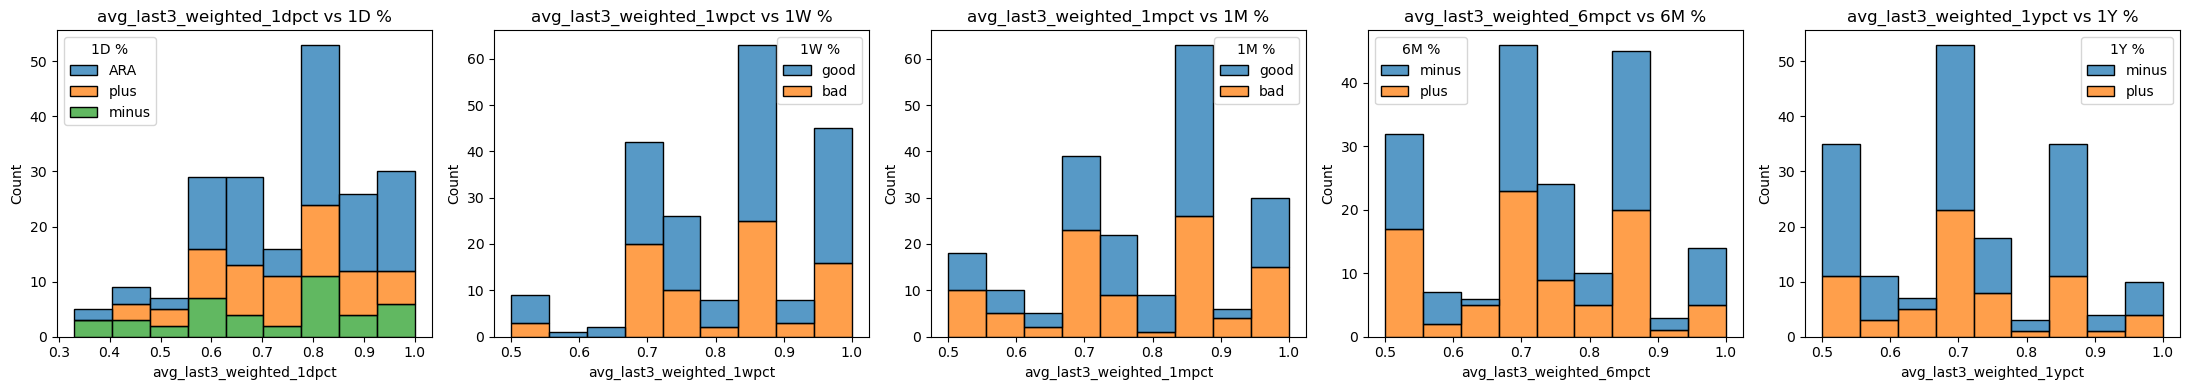

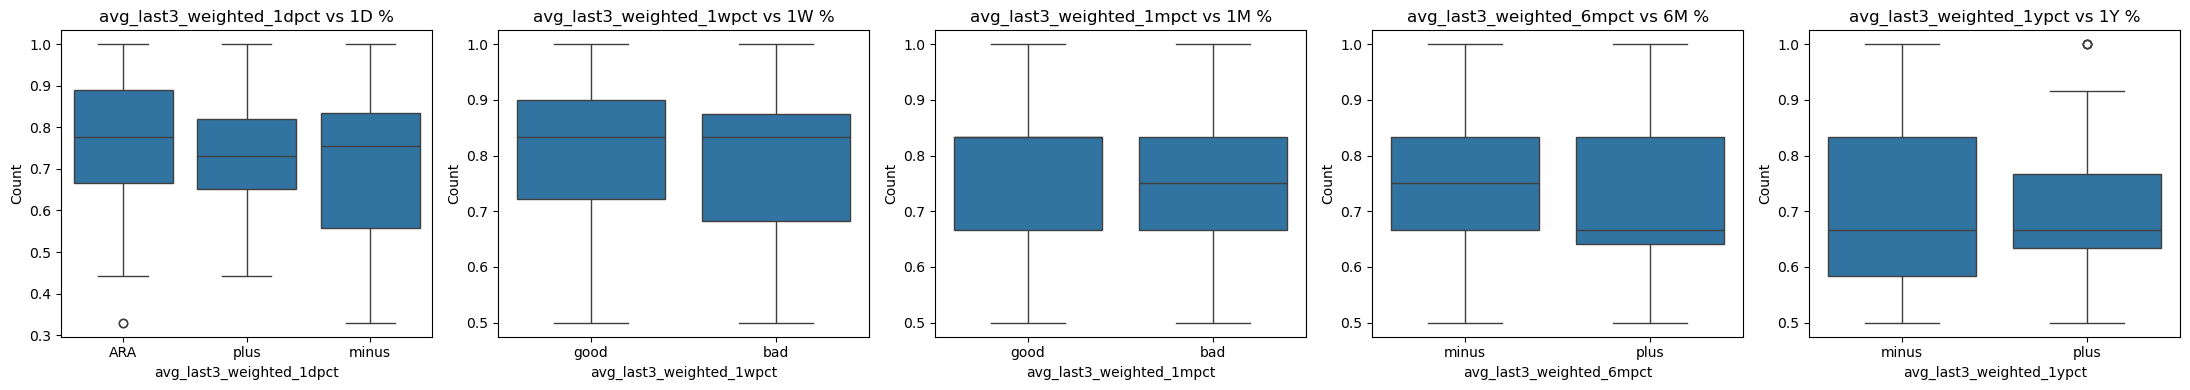

In [72]:
fig, axes = plt.subplots(1, 5, figsize=(22, 4))
plot_pairs = [
    ('avg_last3_weighted_1dpct', '1D %'),
    ('avg_last3_weighted_1wpct', '1W %'),
    ('avg_last3_weighted_1mpct', '1M %'),
    ('avg_last3_weighted_6mpct', '6M %'),
    ('avg_last3_weighted_1ypct', '1Y %'),
]

for i, (x_col, y_col) in enumerate(plot_pairs):
    sns.histplot(data=df_sorted, x=x_col, hue=y_col, multiple="stack", ax=axes[i], kde=False)
    axes[i].set_title(f'{x_col} vs {y_col}')
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(22, 4))
for i, (x_col, y_col) in enumerate(plot_pairs):
    sns.boxplot(data=df_sorted, x=y_col, y=x_col, ax=axes[i])
    axes[i].set_title(f'{x_col} vs {y_col}')
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

**Kesimpulan Histogram**: Fitur "rekam jejak" berhasil menangkap sinyal momentum. Skor yang lebih tinggi secara konsisten berkorelasi dengan probabilitas hasil yang lebih baik.

**Kesimpulan Box Plot**: Analisis ini secara statistik mengkonfirmasi bahwa IPO yang berkinerja baik cenderung berasal dari underwriter yang memiliki skor rekam jejak yang lebih tinggi, dan sebaliknya

### 3. Seasonality

kolom yang mencatat kondisi musim, pada saat saham di listing

In [73]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Rainy'
    elif month in [3, 4, 5]:
        return 'Dry Early'
    elif month in [6, 7, 8]:
        return 'Dry Peak'
    elif month in [9, 10, 11]:
        return 'Dry Late'
    else:
        return 'Unknown'

df['Listing Month'] = df['Tanggal Listing'].dt.month
df['Listing Season'] = df['Listing Month'].apply(month_to_season)
df = df.drop(columns=['Listing Month', 'Tanggal Listing'])
df['Listing Season'].value_counts()

Listing Season
Rainy        74
Dry Peak     60
Dry Late     45
Dry Early    44
Name: count, dtype: int64

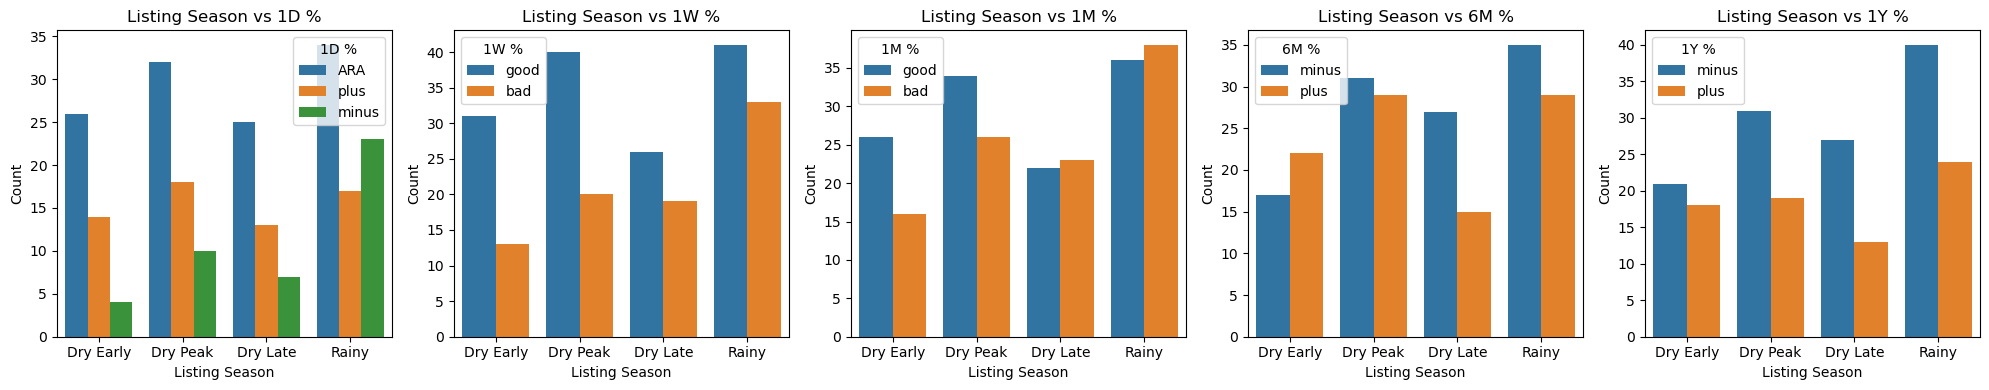

In [74]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    sns.countplot(x=df['Listing Season'], hue=df[col], ax=axes[i])
    axes[i].set_title(f'Listing Season vs {col}')
    axes[i].set_xlabel('Listing Season')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

### 4. Financials

In [75]:
df['ipo_raised_fund'] = df['Listed Share'] * df['Harga Final'] * df['Persen Saham Ditawarkan']

df['equity'] = df['Total Aset'] - df['Total Liabilitas']
df['leverage'] = df['Total Liabilitas'] / df['equity']
df['turnover'] = df['Pendapatan'] / df['Total Aset']


df['PER'] = df['Harga Final'] / (df['Laba Berjalan (Bukan Komperhensif)'] / df['Listed Share'])
df['PBV'] = df['Harga Final'] / (df['equity'] / df['Listed Share'])
df['PER'] = df['PER'].clip(upper=100)
df['PBV'] = df['PBV'].clip(upper=10)

df['ROA'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['Total Aset']
df['ROE'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['equity']
df['NPM'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['Pendapatan']

### 5. Drop yang ga guna

In [76]:
df = df.drop(['Listed Share', 'Rencana Penggunaan Dana IPO', 'Valuation Currency', 'Total Liabilitas', 'Laba Kotor', 'Laba Berjalan (Bukan Komperhensif)'], axis=1)

### 6. Total Aset (Numeric -> Category)

In [77]:
df['Total Aset'] = np.log1p(df['Total Aset'].clip(lower=1e-9))

In [78]:
df['total_aset_category'] = pd.cut(
    df['Total Aset'],
    bins=[-float('inf'), df['Total Aset'].quantile(0.25), df['Total Aset'].quantile(0.75), float('inf')],
    labels=['low', 'mid', 'high']
)

In [79]:
df['total_aset_category'] = df['total_aset_category'].astype('object')

### 7. Harga Final (Numeric -> Category)

In [80]:
df['Harga Final'] = np.log1p(df['Harga Final'])

In [81]:
df['price_category'] = pd.qcut(
    df['Harga Final'], 
    q=4, 
    labels=['very low', 'low', 'mid', 'high']
)

In [82]:
df['price_category'] = df['price_category'].astype('object')

In [83]:
# Map label dari '1Y %' (plus/minus) jadi numerik
df['1Y Label'] = df['1Y %'].map({'plus': 1, 'minus': 0})

# Inisialisasi threshold dan hasil akhir
threshold = 0.5
df_copy = df.copy()
underwriter_kategori = {}

# Ulangi proses hingga tidak ada lagi underwriter yang melebihi threshold
while True:
    # Hitung success rate tiap underwriter di data yang tersisa
    temp_ratio = (
        df_copy.groupby('lead_underwriter')['1Y Label']
        .agg(['sum', 'count'])
        .assign(success_rate=lambda x: x['sum'] / x['count'])
    )
    
    # Cek apakah ada yang di atas threshold
    valid = temp_ratio[temp_ratio['success_rate'] > threshold]
    if valid.empty:
        break

    # Ambil underwriter dengan success rate tertinggi
    best_underwriter = valid['success_rate'].idxmax()
    underwriter_kategori[best_underwriter] = 'Bagus'

    # Buang semua rows yang menggunakan underwriter ini
    df_copy = df_copy[df_copy['lead_underwriter'] != best_underwriter]

# Sisanya otomatis dianggap 'Jelek'
all_underwriters = df['lead_underwriter'].unique()
for u in all_underwriters:
    if u not in underwriter_kategori:
        underwriter_kategori[u] = 'Jelek'

# Mapping ke dataframe asli
df['underwriter_kualitas'] = df['lead_underwriter'].map(underwriter_kategori)


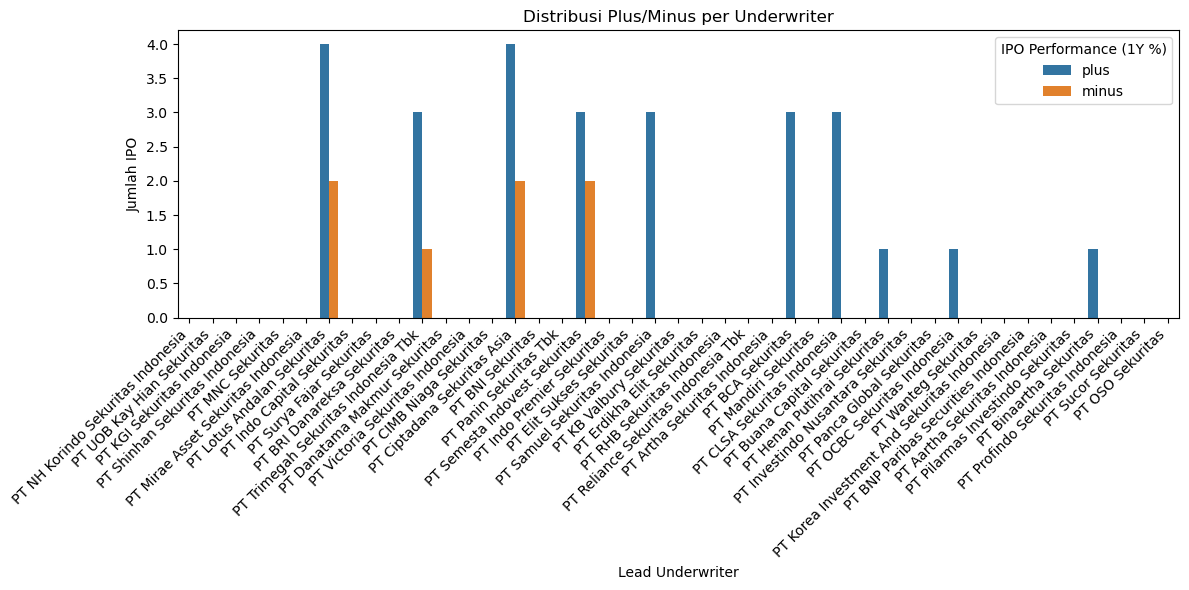

In [84]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=final_df,
    x='lead_underwriter',
    hue='1Y %',
    order=df['lead_underwriter'].value_counts().index
)
plt.xticks(rotation=45, ha='right')
plt.title('Distribusi Plus/Minus per Underwriter')
plt.xlabel('Lead Underwriter')
plt.ylabel('Jumlah IPO')
plt.legend(title='IPO Performance (1Y %)')
plt.tight_layout()
plt.show()

In [87]:
df.drop(columns=['1Y Label'], inplace=True)

## Encoding

In [88]:
df = df.drop('Ticker', axis = 1)
df = df.drop('Nama Perusahaan', axis = 1)

In [89]:
categorical_cols = df.select_dtypes(include='object').columns

orders = {
    'underwriter_freq_category': ['low', 'mid', 'high'],
    'underwriter_avg_aset_category': ['low', 'mid', 'high'],
    'total_aset_category': ['low', 'mid', 'high'],
    'price_category': ['very low', 'low', 'mid', 'high'],
}

manual_orders = orders

label_encoders = {}
encoded_mappings = {}

for col in categorical_cols:
    le = LabelEncoder()
    if col in manual_orders:
        df[col] = pd.Categorical(df[col], categories=manual_orders[col], ordered=True)
        le.classes_ = np.array(manual_orders[col])
        df[col] = le.transform(df[col])
    else:
        df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    encoded_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

## Correlation

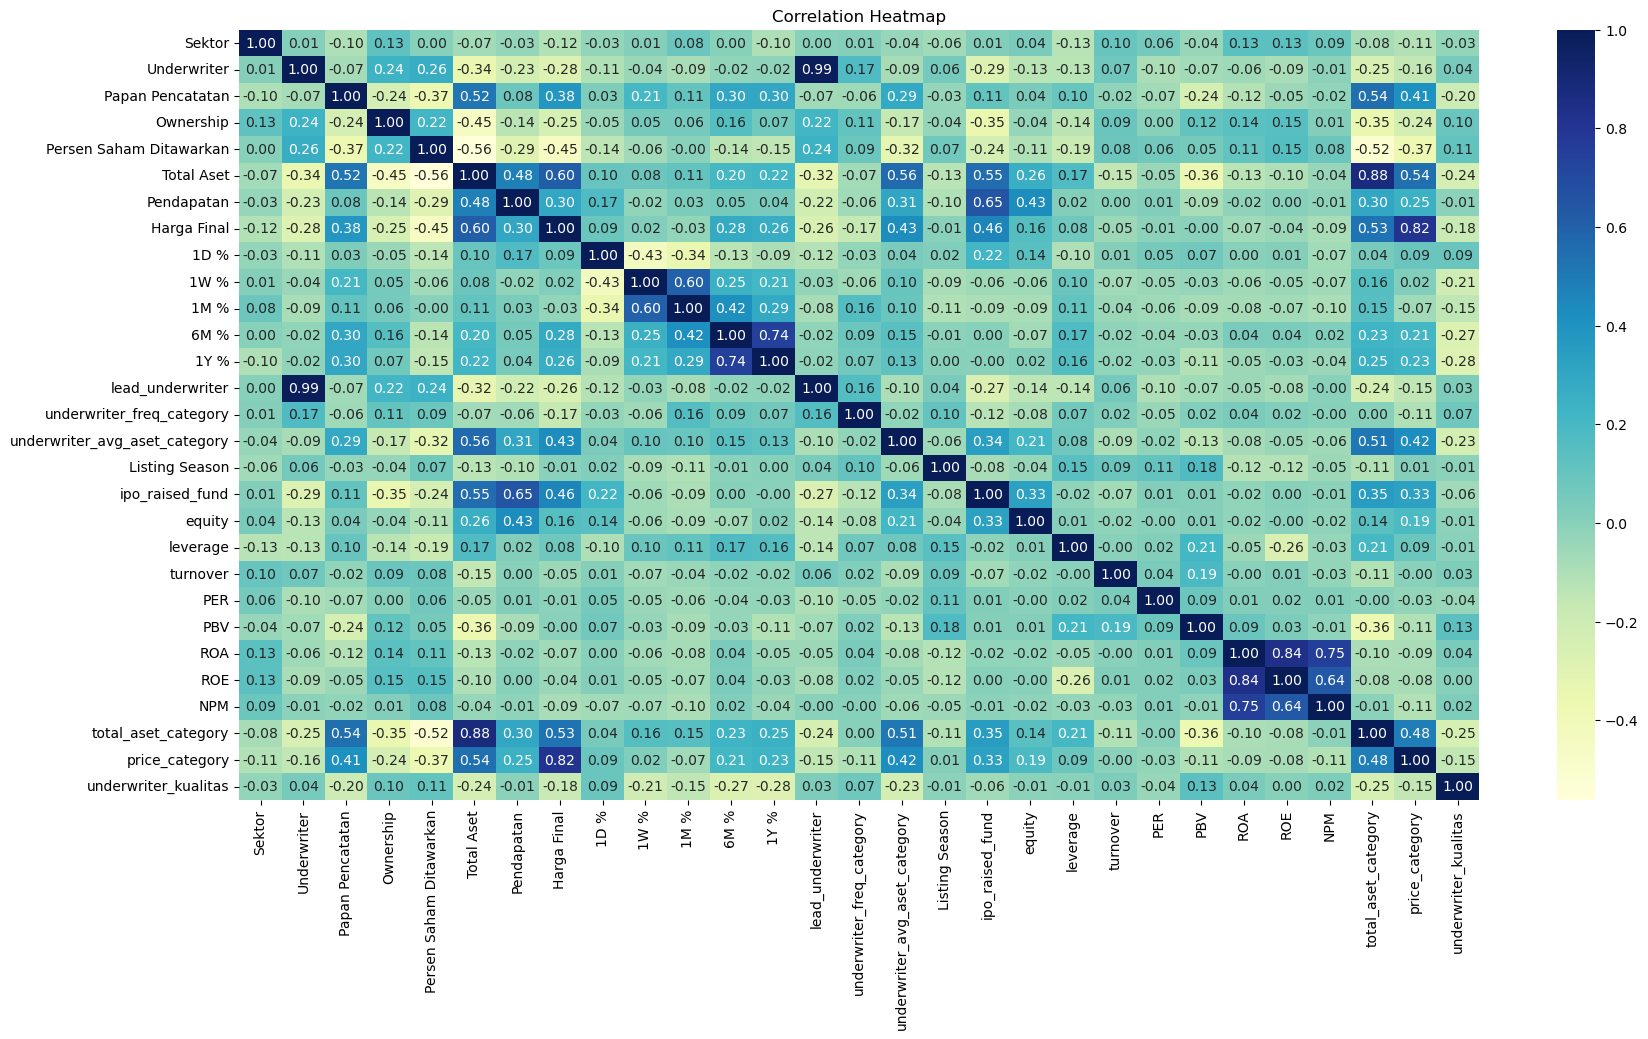

In [90]:
corr = df.iloc[:].corr(method="pearson")

plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

## Training

### 1Y %

In [91]:
feature_cols = [
    'lead_underwriter',                  
    'underwriter_avg_aset_category',     
    'underwriter_kualitas',              
    'turnover',                    
    'total_aset_category',               
    'Papan Pencatatan',                  
    'ipo_raised_fund',                   
    'price_category',                    
    'equity',                            
    'leverage',                          
    'Pendapatan',                        
    'ROE'
]


X = df[feature_cols].apply(LabelEncoder().fit_transform)
y = df['1Y %']

mask = y != 2
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [92]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
weight_dict = dict(zip(np.unique(y), weights))

weight_dict

{0: 0.8109243697478992, 1: 1.304054054054054}

In [93]:
# CatBoost
catboost_grid = {
    'iterations': [300, 500],
    'depth': [4, 6],
    'learning_rate': [0.03, 0.1],
    'l2_leaf_reg': [3, 10],
}

# Random Forest
rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

# XGBoost
xgb_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.03, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [1]
}

In [94]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# CatBoost
cat = CatBoostClassifier(loss_function='Logloss', verbose=0, auto_class_weights='Balanced', random_state=42)
cat_grid = GridSearchCV(cat, catboost_grid, cv=cv, scoring='f1_macro', n_jobs=1)
cat_grid.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf, rf_grid, cv=cv, scoring='f1_macro', n_jobs=1)
rf_grid_search.fit(X_train, y_train)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_grid_search = GridSearchCV(xgb, xgb_grid, cv=cv, scoring='f1_macro', n_jobs=1)
xgb_grid_search.fit(X_train, y_train)

d:\Conda\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Conda\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Conda\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Conda\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:52:44] WARNING: C:\buildki

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importanc...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=1,
             param_grid={'colsample_bytree': [0.8],
                         'learning_rate': [0.03, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'scale_pos_weight': [1],
                         'subsample': [0.8]},
             scoring='f1_macro')

In [99]:
cat_grid.best_params_, rf_grid_search.best_params_, xgb_grid_search.best_params_

({'depth': 6, 'iterations': 500, 'l2_leaf_reg': 10, 'learning_rate': 0.1},
 {'class_weight': 'balanced',
  'max_depth': 7,
  'min_samples_split': 2,
  'n_estimators': 100},
 {'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 5,
  'n_estimators': 100,
  'scale_pos_weight': 1,
  'subsample': 0.8})

In [100]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

catboost_model = CalibratedClassifierCV(
    estimator=CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        l2_leaf_reg=10,
        loss_function='Logloss',
        auto_class_weights='Balanced',
        verbose=0,
        random_state=42
    ),
    method='isotonic',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)

In [101]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=7,
    min_samples_split=2,
    class_weight='balanced',
    random_state=42
)

In [102]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight= weights[1] / weights[0],
    random_state=42,
    reg_alpha=0.1
)

In [108]:
from sklearn.ensemble import VotingClassifier


ensemble_model = VotingClassifier(
    estimators=[
        ('cat', catboost_model),
        ('rf',  rf_model),
        ('xgb', xgb_model)
    ],
    voting='soft',
    weights=[1, 1, 1]
)

ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('cat',
                              CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                                     estimator=<catboost.core.CatBoostClassifier object at 0x000002CD6EF42540>,
                                                     method='isotonic')),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=7,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbac...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft', weights=[1, 1, 1])

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.59      0.70        22
           1       0.62      0.88      0.73        17

    accuracy                           0.72        39
   macro avg       0.75      0.74      0.72        39
weighted avg       0.76      0.72      0.72        39



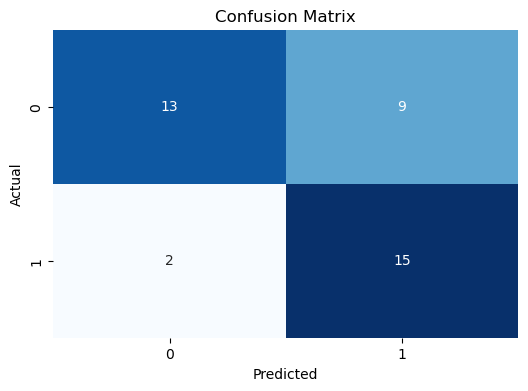

In [109]:
from sklearn.metrics import classification_report, confusion_matrix

probs = ensemble_model.predict_proba(X_test)[:, 1]
y_pred = (probs > 0.32).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [110]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict

import warnings
warnings.filterwarnings("ignore")

thresholds = np.arange(0.3, 0.61, 0.01)
f1_scores = []

probs = cross_val_predict(
    ensemble_model,
    X, y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method='predict_proba'
)[:, 1]

for t in thresholds:
    preds = (probs >= t).astype(int)
    score = f1_score(y, preds, average='macro')
    f1_scores.append(score)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Macro Score: {best_f1:.4f}")

Best Threshold: 0.35
Best F1 Macro Score: 0.6691


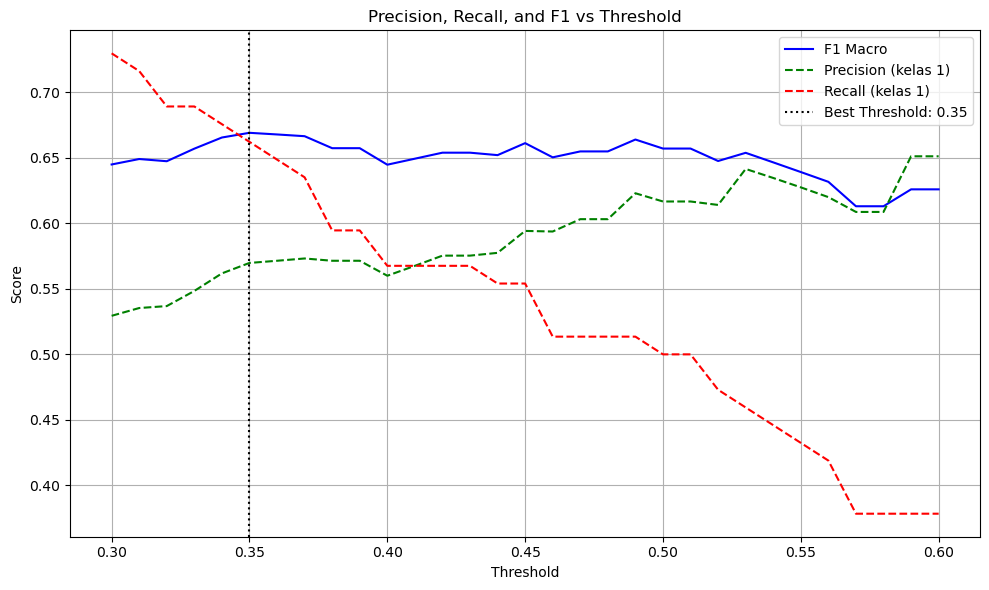

In [111]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

precisions = []
recalls = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    precisions.append(precision_score(y, preds))
    recalls.append(recall_score(y, preds))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Macro', color='blue')
plt.plot(thresholds, precisions, label='Precision (kelas 1)', linestyle='--', color='green')
plt.plot(thresholds, recalls, label='Recall (kelas 1)', linestyle='--', color='red')
plt.axvline(best_threshold, linestyle=':', color='black', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

F1 Score (threshold=0.35000000000000003): 0.6691
Accuracy: 0.6787564766839378


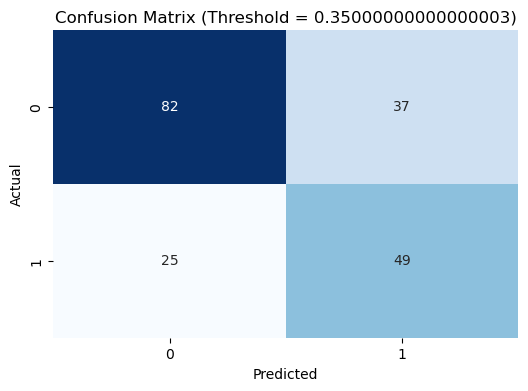

In [112]:
from sklearn.metrics import accuracy_score

probs = cross_val_predict(ensemble_model, X, y, 
                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                          method='predict_proba')[:, 1]

threshold = best_threshold
preds = (probs >= threshold).astype(int)

cm = confusion_matrix(y, preds)
print(f"F1 Score (threshold={threshold}): {f1_score(y, preds, average='macro'):.4f}")
print(f"Accuracy: {accuracy_score(y, preds)}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

### 1D